In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import utils
from torchvision import datasets
from torchvision import transforms

from PIL import Image
import urllib.request as request
from matplotlib import pyplot as plt
#torch.set_printoptions(edgeitems=2) #default 3
#torch.manual_seed(123)

# Construyendo un modelo

---



In [5]:
#tomamos el mismo dataset que el anterior ejercicio y tenemos uno de entrenado y el otro de validacion
#Aqui podemos ver que para la normalizacion tomamos la desveicacion estandar 
data_path = 'data/'
full_data_set = datasets.CIFAR10(data_path, train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                          ]))

full_validation_set = datasets.CIFAR10(data_path, train=False, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                          ]))

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [6]:
#Estoq uiere decir que cada batcha va a ser de 4 imagenes, shuffle significa que que que cargue van a cargar nuevas imagenes
size = 4
dataloader = torch.utils.data.DataLoader(full_data_set, batch_size=size, shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck
horse
bird
cat



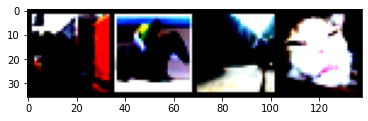

In [7]:
data_iterator = iter(dataloader)
imgs, labels = data_iterator.next()

classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

plt.imshow(utils.make_grid(imgs).permute(1, 2, 0))

for i in range(size):
  print(classes[labels[i]])

In [8]:
#classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

#Aqui se hace un mapeo donde solo nos queremos quedar con el carro y el gato, donde el carro esta en la posicion 1 y el gato en la posicion 3
#Y ahora va a estar posicionado en la la posicion 0 y 1 que se ve en el label_map
class_names = ['car', 'cat']

label_map = {1: 0, 3: 1}

data_set = [(img, label_map[label]) for img, label in full_data_set if label in [1, 3]]
validation_set = [(img, label_map[label]) for img, label in full_validation_set if label in [1, 3]]

In [9]:
img, label = data_set[20]
img.shape

torch.Size([3, 32, 32])

In [10]:
#Vamos a hacer una trasformacion lineal de 32 x 32 x 3, sequential nos permite hacer varias llamadas
#Ponemos 512 que es la salida podria ser un numero mayor o menor pero en base a experiencia se pone 512
#nn.Tanh es funcion de tangente hiperbolica
# Y la salida tambien va a ser lineal con 512 pasos intermedios y mi salida binaria que es 2 porque es un clasificador
model = nn.Sequential(
            nn.Linear(3 * 32 * 32, 512),
            nn.Tanh(),
            nn.Linear(512, 2))

In [11]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

In [12]:
x = torch.tensor([1.0, 2.0, 3.0])

sigmoid(x)

tensor([0.7311, 0.8808, 0.9526])

In [13]:
sigmoid(x).sum()

tensor(2.5644)

In [14]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [15]:
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [16]:
softmax(x).sum()

tensor(1.)

In [17]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [18]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'car'

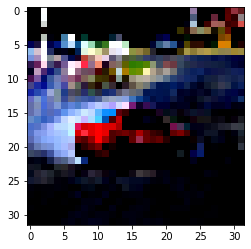

In [19]:
img, label = data_set[20]

plt.imshow(img.permute(1, 2, 0))

class_names[label]

In [20]:
#Aqui lo ponemos en un fomato par que el modelo lo entienda y agregado la dimension esta 
out = model(img.view(-1).unsqueeze(0))
out

tensor([[0.4247, 0.5753]], grad_fn=<SoftmaxBackward>)

In [21]:
_, index = torch.max(out, dim=1)

print('->',class_names[label],' model:',class_names[index])

-> car  model: cat


In [22]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 110.0]])

softmax(x)

tensor([[0., 1.]])

In [23]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [24]:
log_softmax(x)

tensor([[-110.,    0.]])

In [25]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

# Implementando un clasificador totalmente conectado

---

**texto en negrita**

In [26]:
# ponemos softmax con logaritmos
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

loss = nn.NLLLoss()


In [27]:
img, label = data_set[20]

out = model(img.view(-1).unsqueeze(0))

_, index = torch.max(out, dim=1)

print('->',class_names[label],' model:',class_names[index])

loss(out, torch.tensor([label]))

-> car  model: cat


tensor(0.8206, grad_fn=<NllLossBackward>)

In [28]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

In [29]:
learning_rate = 0.01

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

lossFunction = nn.NLLLoss()

n_epochs = 5 #100

for epoch in range(n_epochs):
    for img, label in data_set:
        out = model(img.view(-1).unsqueeze(0))
        loss = lossFunction(out, torch.tensor([label]))
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.466656
Epoch: 1, Loss: 2.351163
Epoch: 2, Loss: 0.000861
Epoch: 3, Loss: 0.000273
Epoch: 4, Loss: 0.005819


In [30]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))


optimizer = optim.SGD(model.parameters(), lr=0.02)

loss_function = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.672309
Epoch: 1, Loss: 0.719982
Epoch: 2, Loss: 0.417245
Epoch: 3, Loss: 0.269388
Epoch: 4, Loss: 0.195847
Epoch: 5, Loss: 0.331612
Epoch: 6, Loss: 0.340972
Epoch: 7, Loss: 0.197822
Epoch: 8, Loss: 0.216234
Epoch: 9, Loss: 0.163705
Epoch: 10, Loss: 0.276327
Epoch: 11, Loss: 0.088256
Epoch: 12, Loss: 0.113214
Epoch: 13, Loss: 0.149653
Epoch: 14, Loss: 0.130156
Epoch: 15, Loss: 0.117532
Epoch: 16, Loss: 0.216741
Epoch: 17, Loss: 0.231998
Epoch: 18, Loss: 0.326185
Epoch: 19, Loss: 0.152621
Epoch: 20, Loss: 0.094557
Epoch: 21, Loss: 0.069267
Epoch: 22, Loss: 0.061116
Epoch: 23, Loss: 0.044276
Epoch: 24, Loss: 0.018605
Epoch: 25, Loss: 0.022974
Epoch: 26, Loss: 0.077435
Epoch: 27, Loss: 0.025315
Epoch: 28, Loss: 0.079583
Epoch: 29, Loss: 0.023017
Epoch: 30, Loss: 0.013670
Epoch: 31, Loss: 0.024131
Epoch: 32, Loss: 0.021182
Epoch: 33, Loss: 0.058240
Epoch: 34, Loss: 0.008001
Epoch: 35, Loss: 0.022012
Epoch: 36, Loss: 0.011889
Epoch: 37, Loss: 0.031245
Epoch: 38, Loss: 0.016

In [31]:
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]

        correct += int((predicted == labels).sum())
      
print("Accuracy: %f" % (correct / total))

Accuracy: 0.864500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->:  car  model: car


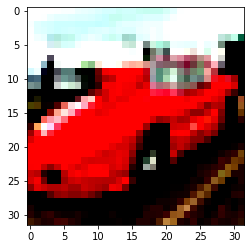

In [32]:
img, label = validation_set[20]
out = model(img.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)

print('->: ',class_names[label],' model:',class_names[index])
plt.imshow(img.permute(1, 2, 0))
plt.show()

# Modelo Mejorado

---



In [33]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)
#el nn.Linear ya multiplicamos mejor todo y ponemos le numero
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

learning_rate = 0.01

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

#usamos nn.crossEntropyLoss en vez de poner el softmax y la funcion de logaritmos negativos "nn.NLLLoss()" porque esa da lo mismo
loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.426898
Epoch: 1, Loss: 0.533422
Epoch: 2, Loss: 0.371377
Epoch: 3, Loss: 0.423190
Epoch: 4, Loss: 0.497851
Epoch: 5, Loss: 0.443907
Epoch: 6, Loss: 0.159740
Epoch: 7, Loss: 0.443528
Epoch: 8, Loss: 0.324510
Epoch: 9, Loss: 0.386812
Epoch: 10, Loss: 0.520380
Epoch: 11, Loss: 0.498327
Epoch: 12, Loss: 0.682972
Epoch: 13, Loss: 0.218888
Epoch: 14, Loss: 0.303053
Epoch: 15, Loss: 0.393745
Epoch: 16, Loss: 0.156022
Epoch: 17, Loss: 0.264236
Epoch: 18, Loss: 0.261478
Epoch: 19, Loss: 0.031304
Epoch: 20, Loss: 0.258864
Epoch: 21, Loss: 0.064199
Epoch: 22, Loss: 0.106436
Epoch: 23, Loss: 0.071834
Epoch: 24, Loss: 0.328661
Epoch: 25, Loss: 0.104217
Epoch: 26, Loss: 0.058233
Epoch: 27, Loss: 0.237293
Epoch: 28, Loss: 0.031742
Epoch: 29, Loss: 0.009728
Epoch: 30, Loss: 0.019190
Epoch: 31, Loss: 0.066978
Epoch: 32, Loss: 0.029914
Epoch: 33, Loss: 0.015272
Epoch: 34, Loss: 0.010635
Epoch: 35, Loss: 0.002947
Epoch: 36, Loss: 0.007474
Epoch: 37, Loss: 0.022962
Epoch: 38, Loss: 0.008

In [34]:
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.858000


In [35]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 1.000000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


correct:  car  model: cat


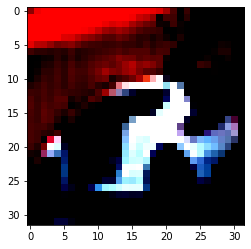

In [36]:
img, label = validation_set[1]
out = model(img.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)

print('correct: ',class_names[label],' model:',class_names[index])
plt.imshow(img.permute(1, 2, 0))

In [37]:
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

3737474

In [38]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

sum([p.numel() for p in first_model.parameters()])

1574402

In [39]:
sum([p.numel() for p in nn.Linear(3072, 512).parameters()])

1573376

In [40]:
sum([p.numel() for p in nn.Linear(3072, 1024).parameters()])

3146752

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


correct: car   model: cat


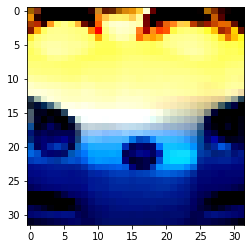

In [41]:
image = request.urlretrieve('https://i.pinimg.com/originals/43/bc/47/43bc47066bb8b2fa4fe7cc8e82cc3714.jpg','test,jpg')
                            
img = Image.open(image[0])

preprocess = transforms.Compose([
        transforms.Resize(48),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4915, 0.4823, 0.4468],
            std=[0.2470, 0.2435, 0.2616]
        )])

img_t = preprocess(img)
out = model(img_t.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)
print('correct: car ',' model:',class_names[index])
plt.imshow(img_t.permute(1, 2, 0))